In [1]:
import json
import pandas as pd
import datetime
from functools import partial
import numpy as np
import scipy.sparse as sparse

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

## Data loading

In [2]:
df = pd.read_json('../data/merged_matches_with_chat.json')

## Data anaylysis

<AxesSubplot: >

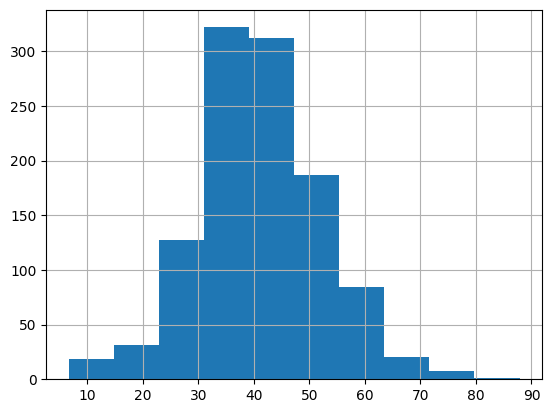

In [4]:
(df.duration / 60).hist()

In [5]:
df.duration.quantile(0.06) / 60

24.493333333333332

In [6]:
# keep only matches with 25min+
df = df[df.duration > 25 * 60]

In [7]:
df.shape

(1037, 53)

## Chat analysis

slot: "Which slot the player is in. 0-127 are Radiant, 128-255 are Dire"

In [8]:
i = 0
one_chat = df.chat.values[i]

In [9]:
pd.Series.value_counts([c['type'] for c in one_chat])

chatwheel    52
chat         31
dtype: int64

In [10]:
[f"{c['key']} : {c['time'] // 60}min" \
 for c in one_chat if c['type'] == 'chat']

["sorry pugna's model didn't load for me and I couldn't click xD : 3min",
 'Xd : 3min',
 'clockwerk seems to have the same issue xD : 6min',
 'and axe : 6min',
 'pay 2 win set : 6min',
 'yea happened to a friend too : 6min',
 'sorry! : 6min',
 'didnt see axe lol : 6min',
 'F9 : 6min',
 'come on : 7min',
 'you guys  : 7min',
 '\ue11e : 7min',
 'need to get better jobs  : 7min',
 'buy pc : 7min',
 '\ue128 : 7min',
 'sorry axe is 13, he cant legally work : 7min',
 'sweatshop : 7min',
 'yea : 7min',
 'legally : 7min',
 "i don't care put him in the mines , they take all sorts of age's : 7min",
 "canm still give BJ's for money : 7min",
 '\ue044 : 7min',
 '\ue10c : 7min',
 '\ue007 : 7min',
 'ty : 7min',
 'axe I hope someone farts on your pillow if you dc again : 7min',
 'gg : 37min',
 'gg : 37min',
 'gg : 37min',
 'gg : 37min',
 'gg : 37min']

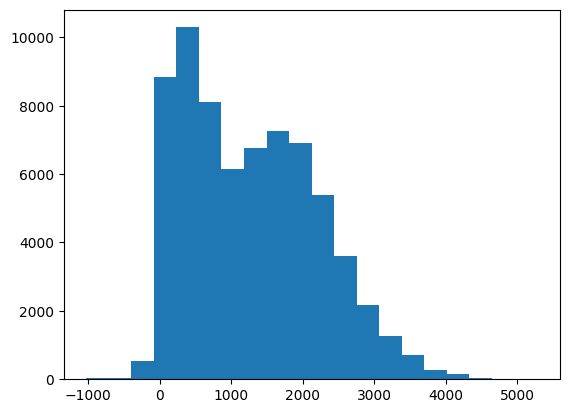

In [11]:
plt.hist(np.hstack(df.chat.apply(
    lambda x: [c['time'] for c in x]).values), bins=20);

## Simple text-only dataset

In [12]:
def select_messages(radiant, time, row):
    chat = row['chat']
    duration = row['duration']
    
    radiant_cond = lambda slot: slot <= 127
    dire_cond = lambda slot: slot > 127
    team_cond = radiant_cond if radiant else dire_cond
    
    return [c['key'] for c in chat \
            if c['type'] == 'chat' \
                and c.get('player_slot') is not None \
                and team_cond(c['player_slot']) \
                and c['time'] < time
#                 and c['time'] <= duration - 5 * 60
           ]

# All following messages will be only for the first 20min
select_n_mins = 20
select_radiant = partial(select_messages, True,
                         select_n_mins * 60)
select_dire = partial(select_messages, False,
                      select_n_mins * 60)

In [13]:
# chat wheel still whould be in the data
df_with_chat = df[df.chat_count > 0].reset_index(drop=True)

In [14]:
df_with_chat.shape

(936, 53)

In [15]:
chat_dataset = {}

chat_dataset['chat_radiant'] = df_with_chat.apply(
    select_radiant, axis=1)
chat_dataset['chat_dire'] = df_with_chat.apply(
    select_dire, axis=1)

chat_dataset = pd.DataFrame(chat_dataset)
chat_dataset_label = df_with_chat.radiant_win.astype(
    float).values

In [16]:
chat_dataset.head()

,chat_radiant,chat_dire
0,"[Xd, yea happened to a friend too, F9, come on...",[sorry pugna's model didn't load for me and I ...
1,"[3 mins, brb, , кто из вас мне роль чурки дал...","[хочешь?, ofc, no problem, кидар красиво делай..."
2,[],[]
3,"[челы, вы конченные у вас керри в топе ебут и ...",[]
4,[],[]


In [17]:
# filter out matches with chatwheel only
non_empty_mask = ((chat_dataset.chat_radiant.apply(len) \
     + chat_dataset.chat_dire.apply(len)) != 0)
chat_dataset = chat_dataset[non_empty_mask]
chat_dataset_label = chat_dataset_label[non_empty_mask]

In [18]:
chat_dataset.shape

(516, 2)

---

In [21]:
pd.Series.value_counts(chat_dataset_label, True)

0.0    0.52907
1.0    0.47093
dtype: float64

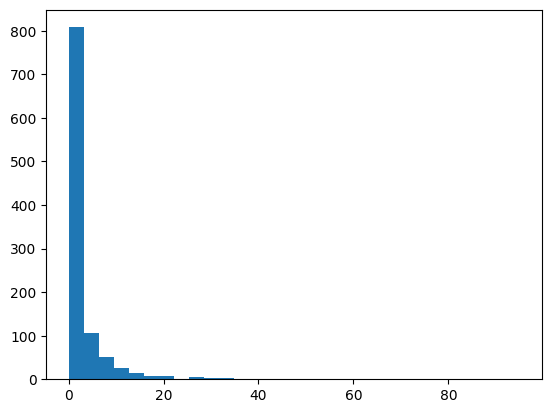

In [23]:
plt.hist(np.hstack((
    chat_dataset.chat_radiant.apply(len),
    chat_dataset.chat_dire.apply(len))), bins=30);

In [24]:
# Mean len for radiant and for dire
(chat_dataset.chat_radiant.apply(len).mean(),
 chat_dataset.chat_dire.apply(len).mean())

(2.9302325581395348, 2.936046511627907)

In [25]:
# Mean len for winner and loser
(np.hstack((chat_dataset[chat_dataset_label == 1]\
    .chat_radiant.apply(len).values,
           chat_dataset[chat_dataset_label == 0]\
    .chat_dire.apply(len).values)).mean(),
 np.hstack((chat_dataset[chat_dataset_label == 0]\
    .chat_radiant.apply(len).values,
           chat_dataset[chat_dataset_label == 1]\
    .chat_dire.apply(len).values)).mean()
)

(2.8294573643410854, 3.0368217054263567)

In [26]:
# matches there one of two teams had empty chat
# it's fine for prediction from both chat and not okay
# for prediction from just one team chat
((chat_dataset.chat_radiant.apply(len) == 0) |\
 (chat_dataset.chat_dire.apply(len) == 0)).sum()

258

## Models

In [422]:
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn import linear_model as lm
from sklearn.model_selection import (
    cross_val_score, train_test_split)
from sklearn.metrics import accuracy_score
import eli5
from sklearn import svm as svm
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler

In [28]:
all_chat = np.hstack((
    chat_dataset.chat_radiant.apply(
        lambda x: ' '.join(x)).values,
    chat_dataset.chat_dire.apply(
        lambda x: ' '.join(x)).values
))

all_chat_labels = np.hstack((
    chat_dataset_label,
    1 - chat_dataset_label
))

In [29]:
# keep matches with empty chat for the following section
vectorizer = CountVectorizer(
    max_features=10_000, min_df=5, ngram_range=(1, 2),
    analyzer='word')
all_chat_features = vectorizer.fit_transform(all_chat)

In [30]:
non_empty_mask = np.array((
    all_chat_features.sum(axis=1) > 0))[:, 0]

all_chat_features_non = all_chat_features[non_empty_mask]
all_chat_labels_non = all_chat_labels[non_empty_mask]

In [31]:
all_chat_features.shape, all_chat_features_non.shape

((1032, 204), (563, 204))

In [33]:
np.array(vectorizer.get_feature_names())[
    np.random.randint(0, all_chat_features.shape[1], 20)]

array(['guys', 'back', 'you', 'ping', 'xd', 'can', 'know', 'хорошо', 'же',
       'bot', 'time', 'дал', 'don', 'lose', 'вы', 'ping', 'ты', 'tu',
       'carry', 'already'], dtype='<U7')

In [70]:
lr = lm.LogisticRegression()

In [73]:
cross_val_score(
    lr, all_chat_features_non, all_chat_labels_non,
    cv=10).mean()

0.5506892230576442

In [74]:
(all_chat_labels_non == 1).mean()

0.49733570159857904

In [75]:
lr.fit(all_chat_features_non, all_chat_labels_non)

LogisticRegression()

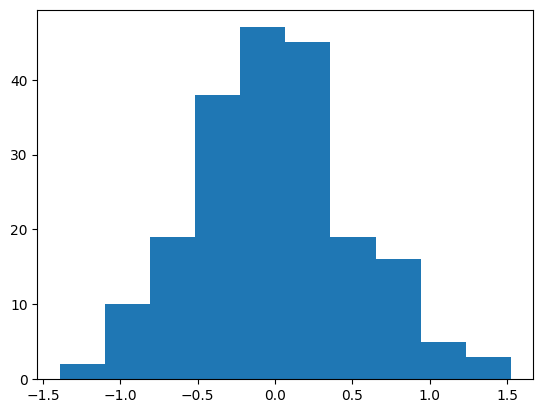

In [76]:
plt.hist(lr.coef_[0]);

In [135]:
# higher coeff means higher chance of winning
# lower coeff means higher chance of losing
eli5.show_weights(lr, vec=vectorizer, top=(20, 20))

Weight?,Feature
+1.523,noobs
+1.380,sry
+1.246,brain
+1.107,more
+1.062,fuck
+1.056,иди
+1.027,es
+1.024,good
+0.909,can
+0.903,за


### Same features and model, but from both teams chat

Prediction from concatenation of radiant and dire chat

In [400]:
dual_chat_features = sparse.hstack((
    all_chat_features[:all_chat_features.shape[0] // 2],
    all_chat_features[all_chat_features.shape[0] // 2:]
))

In [401]:
non_empty_mask = np.array((
    dual_chat_features.sum(axis=1) > 0))[:, 0]

dual_chat_features_non = dual_chat_features[non_empty_mask]
chat_dataset_label_non = chat_dataset_label[non_empty_mask]

In [402]:
# dire wins more
(chat_dataset_label_non == 0).mean()

0.5408163265306123

In [403]:
dual_chat_features_non.shape

(392, 408)

In [404]:
# very ugly undersampling
n_to_drop = chat_dataset_label_non.shape[0] * \
    ((chat_dataset_label_non == 0).mean() - 0.5) + 8

to_fix = n_to_drop
mask_of_bigger_class = chat_dataset_label_non == 0
mask_to_keep = []
for i in range(chat_dataset_label_non.shape[0]):
    if mask_of_bigger_class[i] and to_fix > 0:
        mask_to_keep.append(False)
        to_fix -= 1
    else:
        mask_to_keep.append(True)

dual_chat_features_non_balanced = dual_chat_features_non[
    mask_to_keep]
chat_dataset_label_non_balanced = chat_dataset_label_non[
    mask_to_keep]

In [406]:
dual_chat_features.shape, dual_chat_features_non.shape,\
    dual_chat_features_non_balanced.shape

((516, 408), (392, 408), (367, 408))

In [407]:
# dire wins more
(chat_dataset_label_non_balanced == 0).mean()

0.5095367847411444

In [408]:
lr_dual = lm.LogisticRegression()

In [409]:
cross_val_score(
    lr_dual, dual_chat_features_non_balanced,
    chat_dataset_label_non_balanced,
    cv=10).mean()

0.6052552552552553

In [410]:
lr_dual.fit(dual_chat_features_non_balanced,
            chat_dataset_label_non_balanced)

LogisticRegression()

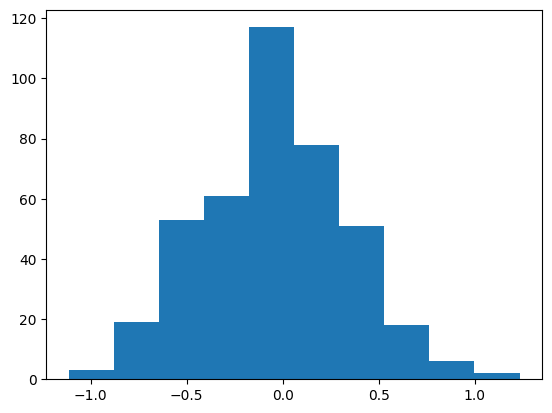

In [411]:
plt.hist(lr_dual.coef_[0]);

In [412]:
feature_names = [
    f'r: {x}' for x in vectorizer.get_feature_names_out()
] + [
    f'd: {x}' for x in vectorizer.get_feature_names_out()
]

In [413]:
# higher coeff means higher chance of radiant winning
# lower coeff means higher chance of dire winning
# "r:" preffix means word from radiant chat
# "d:" preffix means word from dire chat
eli5.show_weights(
    lr_dual, feature_names=feature_names, top=(20, 20))

Weight?,Feature
+1.233,d: and
+1.070,d: ok
+0.959,d: че
+0.888,r: gl
+0.841,d: time
+0.819,d: too
+0.797,d: вы
+0.765,d: тебе
+0.754,d: haha
+0.735,r: fuck


## Wordcloud

In [414]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [415]:
import nltk
nltk.download("stopwords")
russian_stopwords = nltk.corpus.stopwords.words("russian")
stop_words = list(STOPWORDS) + russian_stopwords \
    + ['же', 'на', 'за', 'ну']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ekashin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cloud for all words

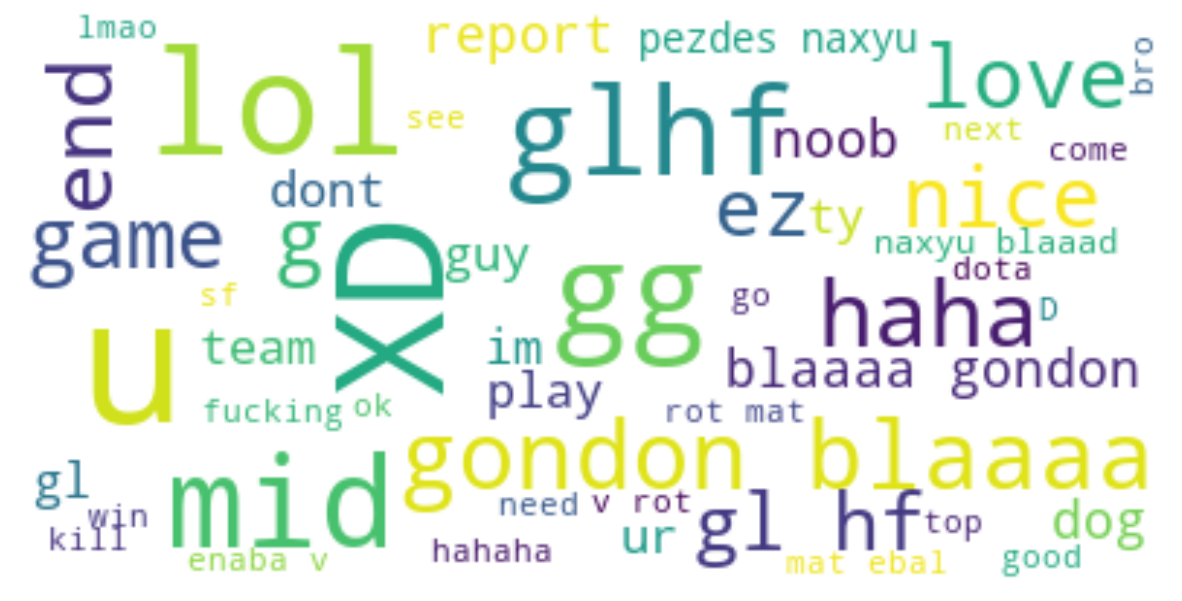

In [418]:
wordcloud = WordCloud(
    max_font_size=60, max_words=50,
    background_color="white",
    stopwords=stop_words).generate(' '.join(all_chat))

plt.figure(figsize=(15, 10))
# plt.title("Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Cloud for "winning" words

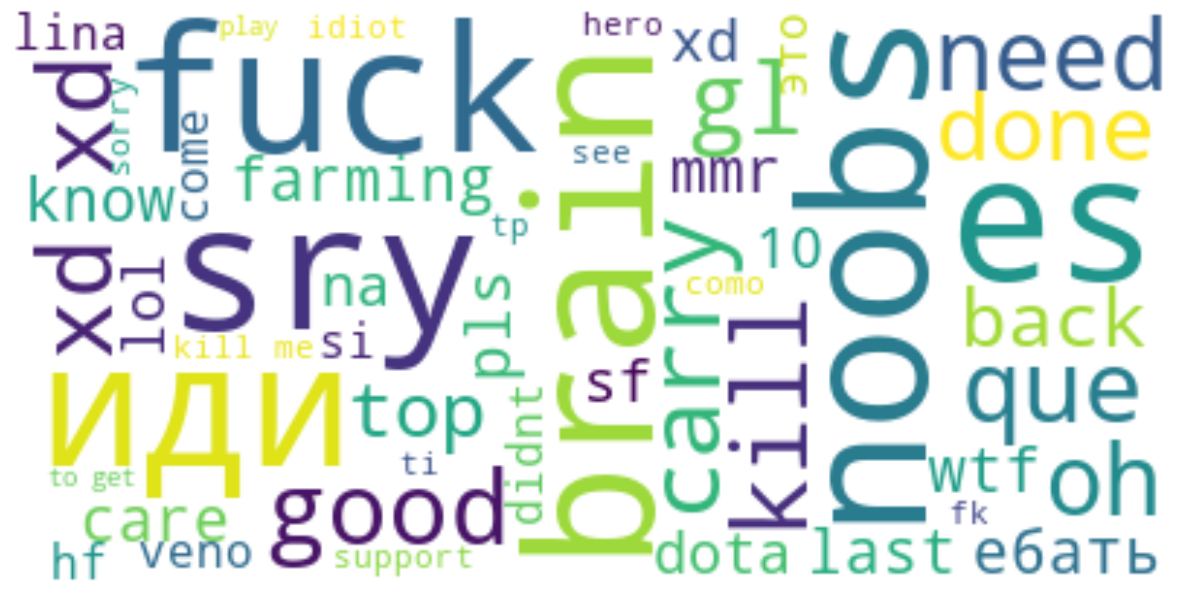

In [420]:
features_mask = (lr.coef_ > 0)[0]
features_freq = dict(zip(
    np.array(vectorizer.get_feature_names_out())[
        features_mask],
    lr.coef_[0][features_mask]))
features_freq = {k: v for k, v in features_freq.items() \
                 if k not in stop_words}

wordcloud = WordCloud(
    max_font_size=60, max_words=50,
    background_color="white",
    relative_scaling=0,
    stopwords=stop_words).generate_from_frequencies(
        features_freq
    )

plt.figure(figsize=(15, 10))
# plt.title("Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Cloud for "lossing" words

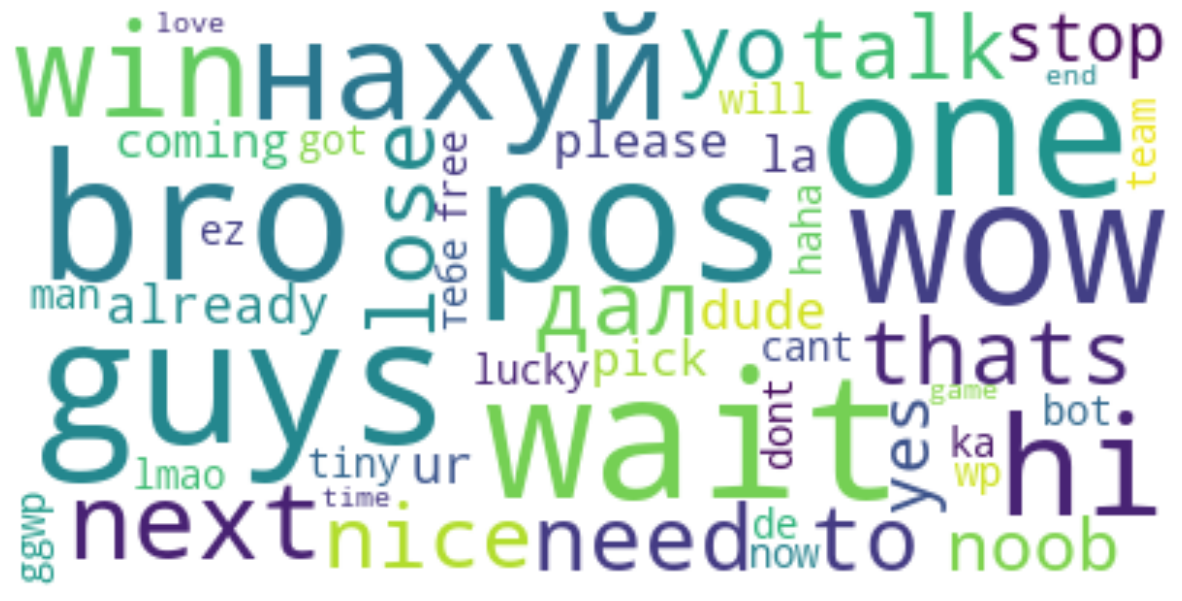

In [421]:
features_mask = (lr.coef_ < 0)[0]
features_freq = dict(zip(
    np.array(vectorizer.get_feature_names_out())[
        features_mask],
    lr.coef_[0][features_mask]))
features_freq = {k: v for k, v in features_freq.items() \
                 if k not in stop_words}

wordcloud = WordCloud(
    max_font_size=60, max_words=50,
    background_color="white",
    relative_scaling=0,
    stopwords=stop_words).generate_from_frequencies(
        features_freq
    )

plt.figure(figsize=(15, 10))
# plt.title("Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## "Better" models

### All text features

In [423]:
def select_message_data(radiant, time, row):
    chat = row['chat']
    duration = row['duration']
    
    radiant_cond = lambda slot: slot <= 127
    dire_cond = lambda slot: slot > 127
    team_cond = radiant_cond if radiant else dire_cond
    
    return [c for c in chat \
            if c.get('player_slot') is not None \
                and team_cond(c['player_slot']) \
                and c['time'] < time
           ]

select_n_mins = 20
select_radiant = partial(select_message_data, True,
                         select_n_mins * 60)
select_dire = partial(select_message_data, False,
                      select_n_mins * 60)

In [424]:
chat_dataset = {}

chat_dataset['chat_radiant'] = df_with_chat.apply(
    select_radiant, axis=1)
chat_dataset['chat_dire'] = df_with_chat.apply(
    select_dire, axis=1)

chat_dataset = pd.DataFrame(chat_dataset)
chat_dataset_label = df_with_chat.radiant_win.astype(
    float).values

In [425]:
unique_players = lambda m: \
    len(set([x['player_slot'] for x in m]))
chatwheel_frac = lambda m: \
    sum([x['type'] == 'chatwheel' for x in m]) /\
    (len(m) if len(m) != 0 else 1)
chat_before_start_frac = lambda m: \
    sum([x['time'] < 0 for x in m]) /\
    (len(m) if len(m) != 0 else 1)
chat_time_mean = lambda m: np.mean([x['time'] for x in m])
chat_time_std = lambda m: np.std([x['time'] for x in m])
chat_len_mean = lambda m: np.mean(
    [len(x['key']) for x in m if x['type'] == 'chat'])
chat_len_std = lambda m: np.std(
    [len(x['key']) for x in m if x['type'] == 'chat'])

In [426]:
def create_chat_data_features(chat):
    data_features = {}
    for name, func in [
        ['len', len],
        ['unique_players', unique_players],
        ['chatwheel_frac', chatwheel_frac],
        ['chat_before_start_frac', chat_before_start_frac],
        ['chat_time_mean', chat_time_mean],
        ['chat_time_std', chat_time_std],
        ['chat_len_mean', chat_len_mean],
        ['chat_len_std', chat_len_std],
    ]:
        data_features[name] = chat.apply(func)
    return pd.DataFrame(data_features).fillna(0)

In [427]:
chat_data_features = pd.concat((
    create_chat_data_features(chat_dataset.chat_radiant),
    create_chat_data_features(chat_dataset.chat_dire)))

chat_data_features = chat_data_features.reset_index(
    drop=True)

all_chat_labels = np.hstack((
    chat_dataset_label,
    1 - chat_dataset_label
))

/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [430]:
chat_data_features.head()

,len,unique_players,chatwheel_frac,chat_before_start_frac,chat_time_mean,chat_time_std,chat_len_mean,chat_len_std
0,45,5,0.711111,0.022222,416.177778,162.521559,18.307692,20.154727
1,73,4,0.698630,0.493151,73.767123,306.510789,10.636364,10.284788
2,9,2,1.000000,0.000000,462.222222,80.933138,0.000000,0.000000
3,6,2,0.500000,0.000000,567.666667,255.185336,25.000000,22.642144
4,12,3,1.000000,0.000000,480.833333,300.236527,0.000000,0.000000


In [431]:
chat_data_features.shape

(1872, 8)

---

In [432]:
rf = ensemble.RandomForestClassifier()

In [433]:
cross_val_score(
    rf, chat_data_features, all_chat_labels,
    cv=10).mean()

0.4962623734213222

In [434]:
(all_chat_labels_non == 1).mean()

0.49733570159857904

In [435]:
rf.fit(chat_data_features, all_chat_labels)

RandomForestClassifier()

In [436]:
eli5.explain_weights(rf,
    feature_names=chat_data_features.columns.tolist())

Weight,Feature
0.2491 ± 0.0385,chat_time_mean
0.2321 ± 0.0449,chat_time_std
0.1525 ± 0.0317,len
0.1121 ± 0.0303,chat_before_start_frac
0.0752 ± 0.0279,chat_len_mean
0.0687 ± 0.0280,chatwheel_frac
0.0623 ± 0.0278,unique_players
0.0480 ± 0.0233,chat_len_std


### Same features and model, but from both teams chat

In [438]:
dual_chat_data_features = pd.merge(
    chat_data_features[:chat_data_features.shape[0] // 2]\
        .reset_index(drop=True),
    chat_data_features[chat_data_features.shape[0] // 2:]\
        .reset_index(drop=True),
    left_index=True, right_index=True,
    suffixes=('_r', '_d'))

In [439]:
rf = ensemble.RandomForestClassifier()

In [440]:
cross_val_score(
    rf, dual_chat_data_features, chat_dataset_label,
    cv=10).mean()

0.5555479295355754

In [442]:
(chat_dataset_label == 0).mean()

0.5224358974358975

In [443]:
rf.fit(dual_chat_data_features, chat_dataset_label)

RandomForestClassifier()

In [444]:
dual_chat_data_features.shape

(936, 16)

In [445]:
eli5.explain_weights(rf,
    feature_names=dual_chat_data_features.columns.tolist())

Weight,Feature
0.1115 ± 0.0571,chat_time_mean_d
0.1044 ± 0.0495,chat_time_std_d
0.1024 ± 0.0500,chat_time_std_r
0.0981 ± 0.0597,chat_time_mean_r
0.0917 ± 0.0438,len_r
0.0884 ± 0.0429,len_d
0.0621 ± 0.0413,chat_before_start_frac_r
0.0573 ± 0.0366,chat_before_start_frac_d
0.0440 ± 0.0290,unique_players_d
0.0405 ± 0.0332,chatwheel_frac_d


## Transformers models

In [446]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel
import numpy as np
from scipy.special import softmax
import torch
import csv
import urllib.request
from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [447]:
((chat_dataset.chat_radiant.apply(len) + \
chat_dataset.chat_dire.apply(len)) == 0).sum()

3

In [2306]:
all_chat_splitted = np.hstack((
    chat_dataset.chat_radiant.values,
    chat_dataset.chat_dire.values
))

In [2308]:
non_empty_mask = [len(c) > 0 for c in all_chat_splitted]

# keep for prediction from 2 teams chat
# all_chat_splitted = all_chat_splitted[non_empty_mask]
# all_chat_labels_splitted = all_chat_labels[non_empty_mask]

In [2309]:
def get_df_sentiment_prediction(messages):
    all_chat_sentiment = {}
    is_neg_all = []
    for c in tqdm(messages):
        is_neg = [classifier(
            m, top_k=1)[0]['label'] \
                  == 'NEGATIVE' for m in c]
        is_neg_all.append(is_neg)
    
    all_chat_sentiment['is_neg_mean'] = [np.mean(x) \
     if len(x) > 0 else 1 for x in is_neg_all]
    all_chat_sentiment['is_neg_std'] = [np.std(x) \
     if len(x) > 0 else 1 for x in is_neg_all]
    
    return pd.DataFrame(all_chat_sentiment)

In [2310]:
all_chat_sentiment = get_df_sentiment_prediction(
    all_chat_splitted)

100%|█████████████████████████████████████████████████████████████████████| 1032/1032 [00:55<00:00, 18.64it/s]


https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you

In [2311]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

def postprocess_raw_pred(row, labels):
    k = len(labels)
    n = len(row)
    temp_out = np.zeros((n, k))
    for i, p in enumerate(row):
        pos = np.argmax(p)
        temp_out[i, pos] = 1
    return temp_out.mean(axis=0)

def postprocess_pred(pred, labels):
    all_pred = [
        postprocess_raw_pred(p, labels) for p in pred]
    return np.vstack(all_pred)

def get_df_text_prediction(messages, task='emotion'):
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    model = AutoModelForSequenceClassification\
        .from_pretrained(MODEL)
    

    def pred(m):
        encoded_input = tokenizer(m, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        return softmax(scores)

    pred_all = []
    for c in tqdm(all_chat_splitted):
        pred_all.append([pred(m) for m in c])
    pred_all = postprocess_pred(pred_all, labels)
    
    return pd.DataFrame(
        pred_all, columns=labels)

In [2312]:
all_chat_emotion = get_df_text_prediction(
    all_chat_splitted, 'emotion')

all_chat_offensive = get_df_text_prediction(
    all_chat_splitted, 'offensive')

all_chat_irony = get_df_text_prediction(
    all_chat_splitted, 'irony')

100%|█████████████████████████████████████████████████████████████████████| 1032/1032 [01:58<00:00,  8.73it/s]
/var/folders/_1/51tlm4vx6rj6_81hp_5k3rg00000gn/T/ipykernel_5098/4173599937.py:12: RuntimeWarning: Mean of empty slice.
  return temp_out.mean(axis=0)
/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [2319]:
all_chat_sentiment_featurs = pd.merge(
    pd.merge(
    pd.merge(all_chat_sentiment,
    all_chat_offensive, left_index=True, right_index=True),
    all_chat_emotion, left_index=True, right_index=True),
    all_chat_irony, left_index=True, right_index=True)

all_chat_sentiment_featurs = \
    all_chat_sentiment_featurs.drop(
    ['not-offensive', 'non_irony'], axis=1)

In [2322]:
all_chat_labels_splitted.shape

(774,)

In [2323]:
all_chat_sentiment_featurs_non = \
    all_chat_sentiment_featurs[non_empty_mask]

all_chat_labels_splitted_non = \
    all_chat_labels[non_empty_mask]

In [2372]:
all_chat_sentiment_featurs_non['labels'] = \
    all_chat_labels_splitted_non
all_chat_sentiment_featurs_non['chat'] = \
    all_chat_splitted[non_empty_mask]

In [2373]:
all_chat_sentiment_featurs_non.groupby('labels').mean()

/var/folders/_1/51tlm4vx6rj6_81hp_5k3rg00000gn/T/ipykernel_5098/1753089805.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_chat_sentiment_featurs_non.groupby('labels').mean()


,is_neg_mean,is_neg_std,offensive,anger,joy,optimism,sadness,irony
labels,,,,,,,,
0.0,0.546917,0.211773,0.045828,0.303687,0.521698,0.026290,0.148325,0.170799
1.0,0.531798,0.199747,0.049194,0.277824,0.514401,0.020591,0.187184,0.188602


In [2394]:
all_chat_sentiment_featurs_non\
    .sort_values('offensive').chat.tail(10).reset_index(drop=True)

0       [lol commits 4 to kill me]
1           [suck my dick and die]
2    [where teh fuick u placed it]
3                  [fu9cking nerd]
4       [why are you so toxic sir]
5                       [fuck off]
6                     [brain dead]
7                       [fuck you]
8         [INVISIBLE BUTT BUDDIES]
9    [congrats. fuckin pussy cunt]
Name: chat, dtype: object

In [2393]:
all_chat_sentiment_featurs_non\
    .sort_values('irony').chat.tail(10).reset_index(drop=True)

0                 [ahahahahaha, aHAHAHAHAHAHA]
1                                         [ty]
2              [WOW :), you are good kind sir]
3    [just like how your mom doesn't need you]
4                                        [LOL]
5                            [bye noobs, lul ]
6                       [techies is mid, care]
7                                        [YES]
8                                 [bang, bang]
9                     [bang, bang, bang, Bang]
Name: chat, dtype: object

In [2326]:
all_chat_sentiment_featurs_non = \
    all_chat_sentiment_featurs_non\
    .drop(['labels', 'chat'], axis=1)

---

In [2327]:
rf = ensemble.RandomForestClassifier()

In [2328]:
cross_val_score(
    rf, all_chat_sentiment_featurs_non,
    all_chat_labels_splitted_non,
    cv=10).mean()

0.49510489510489497

In [2329]:
(all_chat_labels_splitted_non == 1).mean()

0.49612403100775193

In [2330]:
rf.fit(all_chat_sentiment_featurs_non,
       all_chat_labels_splitted_non)

RandomForestClassifier()

In [2331]:
eli5.explain_weights(rf,
    feature_names=all_chat_sentiment_featurs_non\
                     .columns.tolist())

Weight,Feature
0.2045 ± 0.0819,irony
0.1494 ± 0.0770,joy
0.1457 ± 0.0830,is_neg_mean
0.1429 ± 0.0663,anger
0.1201 ± 0.0608,sadness
0.1051 ± 0.0578,is_neg_std
0.0833 ± 0.0441,offensive
0.0490 ± 0.0363,optimism


In [2332]:
from sklearn.feature_selection import RFECV

In [2333]:
rf = ensemble.RandomForestClassifier(n_estimators=200)

Optimal number of features : 2


/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


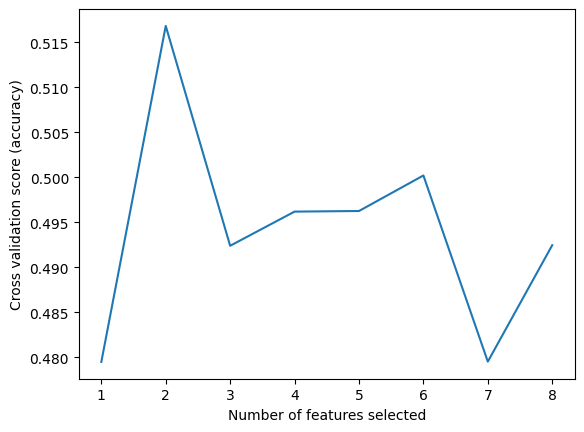

In [2334]:
min_features_to_select = 1
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=10,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(all_chat_sentiment_featurs_non,
          all_chat_labels_splitted_non)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select,
          len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.mean(axis=1),
)
plt.show()

In [2338]:
cross_val_score(
    rf,
    all_chat_sentiment_featurs_non[
        rfecv.get_feature_names_out()],
    all_chat_labels_splitted_non,
    cv=10).mean()

0.5116050616050616

In [2339]:
(all_chat_labels_splitted_non == 1).mean()

0.49612403100775193

In [2340]:
rfecv.get_feature_names_out()

array(['is_neg_mean', 'joy'], dtype=object)

---

In [2343]:
dual_chat_sentiment_featurs = pd.merge(
    all_chat_sentiment_featurs[
        :all_chat_sentiment_featurs.shape[0] // 2]\
        .reset_index(drop=True),
    all_chat_sentiment_featurs[
        all_chat_sentiment_featurs.shape[0] // 2:]\
        .reset_index(drop=True),
    left_index=True, right_index=True,
    suffixes=('_r', '_d'))

In [2344]:
dual_chat_sentiment_featurs.shape

(516, 16)

In [2345]:
chat_dataset_label.shape # (from all_chat_labels.shape)

(516,)

In [2349]:
dual_chat_sentiment_featurs = \
    dual_chat_sentiment_featurs.fillna(-1)

In [2350]:
rf = ensemble.RandomForestClassifier()

In [2351]:
cross_val_score(
    rf, dual_chat_sentiment_featurs,
    chat_dataset_label,
    cv=10).mean()

0.523604826546003

In [2329]:
(all_chat_labels_splitted_non == 1).mean()

0.49612403100775193

In [2352]:
rf.fit(dual_chat_sentiment_featurs,
       chat_dataset_label)

RandomForestClassifier()

In [2353]:
eli5.explain_weights(rf,
    feature_names=dual_chat_sentiment_featurs\
                     .columns.tolist())

Weight,Feature
0.0923 ± 0.0541,irony_d
0.0900 ± 0.0572,is_neg_mean_r
0.0844 ± 0.0535,irony_r
0.0814 ± 0.0537,joy_r
0.0791 ± 0.0575,anger_r
0.0789 ± 0.0546,is_neg_mean_d
0.0685 ± 0.0469,sadness_d
0.0663 ± 0.0522,joy_d
0.0661 ± 0.0519,anger_d
0.0589 ± 0.0457,is_neg_std_r


---

In [2355]:
rf = ensemble.RandomForestClassifier(n_estimators=200)

Optimal number of features : 5


/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


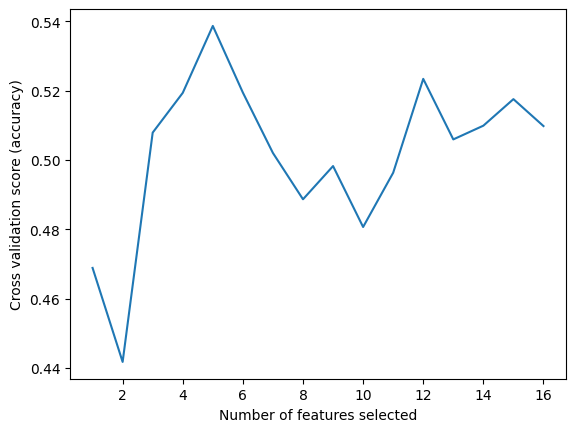

In [2356]:
min_features_to_select = 1
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=10,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(dual_chat_sentiment_featurs,
          chat_dataset_label)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select,
          len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_.mean(axis=1),
)
plt.show()

In [2369]:
cross_val_score(
    rf,
    dual_chat_sentiment_featurs[
        rfecv.get_feature_names_out()],
    chat_dataset_label,
    cv=10).mean()

0.5386123680241328

In [2370]:
(chat_dataset_label == 1).mean()

0.47093023255813954

In [2371]:
rfecv.get_feature_names_out()

array(['is_neg_mean_r', 'joy_r', 'is_neg_mean_d', 'joy_d', 'irony_d'],
      dtype=object)

### BERT embeddings + LR

https://huggingface.co/distilbert-base-uncased?text=Paris+is+the+%5BMASK%5D+of+France.

In [2395]:
MODEL = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# PT
model = AutoModel.from_pretrained(MODEL)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2479]:
def get_embeddings(messages):
    emb_size = 768
    def embed_message(m):
        encoded_input = tokenizer(m, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input,
                           return_dict=True)
        embs = output.last_hidden_state
        embs = embs.sum(axis=1) /\
            encoded_input['attention_mask']\
            .sum(axis=1).unsqueeze(axis=1)
        embs = embs[0]
        return embs.numpy()
    
    embeddings = []
    for c in tqdm(messages):
        team_embeddings = [embed_message(m) for m in c]
        team_embeddings = np.mean(team_embeddings, axis=0)
        embeddings.append(team_embeddings \
            if isinstance(team_embeddings, np.ndarray) \
            else np.zeros(emb_size))
    return embeddings

In [2480]:
embeddings_bert = get_embeddings(all_chat_splitted)
embeddings_bert = np.array(embeddings_bert)

100%|█████████████████████████████████████████████████████████████████████| 1032/1032 [00:53<00:00, 19.13it/s]


In [2481]:
embeddings_bert.shape

(1032, 768)

In [2482]:
embeddings_bert_non = embeddings_bert[non_empty_mask]

In [2522]:
embeddings_bert_non_tr = StandardScaler()\
    .fit_transform(embeddings_bert_non)

In [2527]:
# lr = lm.SGDClassifier()
lr = lm.LogisticRegression(C=0.1)

In [ ]:
cross_val_score(
    lr, embeddings_bert_non_tr,
    all_chat_labels_splitted_non,
    cv=10).mean()

In [2529]:
(all_chat_labels_splitted_non == 1).mean()

0.49612403100775193

In [ ]:
lr.fit(embeddings_bert_non_tr, all_chat_labels_splitted_non)

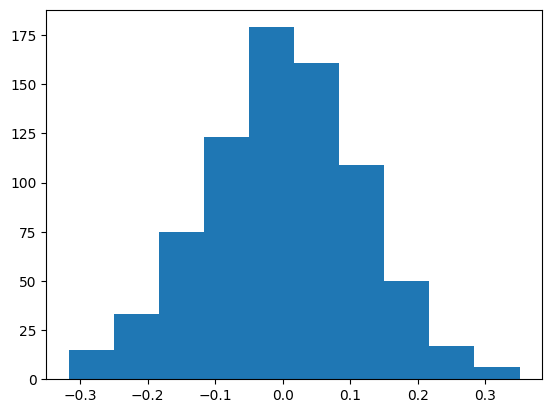

In [2531]:
plt.hist(lr.coef_[0]);

In [2497]:
# eli5.explain_weights(lr)

---

https://huggingface.co/sentence-transformers/sentence-t5-xxl

t5-xxl was too big for my mac. TODO: try "sentence-t5-base"

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/sentence-t5-xxl')
embeddings = model.encode(sentences)
print(embeddings)

---

### LaBSE + LR

https://huggingface.co/sentence-transformers/LaBSE

The main advantage - this model was trained on multi language data

In [2533]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [2538]:
def get_embeddings(messages):
    emb_size = 768
    
    embeddings = []
    for c in tqdm(messages):
        team_embeddings = model.encode(c)
        team_embeddings = np.mean(team_embeddings, axis=0)
        embeddings.append(team_embeddings \
            if isinstance(team_embeddings, np.ndarray) \
            else np.zeros(emb_size))
    return embeddings

In [2540]:
embeddings_labse = get_embeddings(all_chat_splitted)
embeddings_labse = np.array(embeddings_labse)

  0%|▎                                                                       | 5/1032 [00:00<01:10, 14.50it/s]/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ekashin/opt/miniconda3/envs/dota2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████| 1032/1032 [00:37<00:00, 27.89it/s]


In [2544]:
embeddings_labse.shape

(1032, 768)

In [2555]:
embeddings_labse_non = embeddings_labse[non_empty_mask]

In [2556]:
from sklearn.preprocessing import StandardScaler

In [2558]:
embeddings_labse_non_tr = StandardScaler()\
    .fit_transform(embeddings_bert_non)

In [2567]:
lr = lm.SGDClassifier()  # better here
# lr = lm.LogisticRegression(C=1)

In [2568]:
cross_val_score(
    lr, embeddings_labse_non,
    all_chat_labels_splitted_non,
    cv=10).mean()

0.5207792207792208

In [2569]:
(all_chat_labels_splitted_non == 1).mean()

0.49612403100775193

In [2570]:
lr.fit(embeddings_labse_non, all_chat_labels_splitted_non)

SGDClassifier()

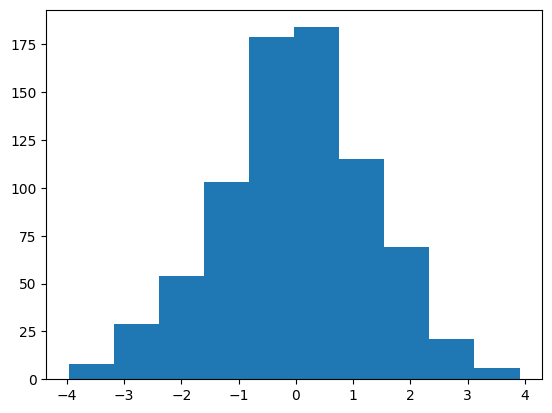

In [2571]:
plt.hist(lr.coef_[0]);

In [ ]:
# eli5.explain_weights(lr)